# Test annotated data

In [1]:
import json
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.methods.dataset import URL_DATA_VAL
# import requests
# print(URL_DATA_VAL)
# annotated_data = json.loads(requests.get(URL_DATA_VAL).text)
annotated_data = json.load(open('../data/val.json', 'r'))

In [2]:
print(json.dumps(annotated_data[10]))

{"video_id": "b72mXcSFozc", "video_start_time": 41, "video_end_time": 51, "caption": "An old man is outside hammering nails into a stone block.", "masked_caption": "An old man is outside hammering nails into _____.", "label": "a stone block", "additional_answers": [["a piece of granite", "a slab of granite", "a long chunk of granite"], ["cement", "rock", "a boulder", "stone", "granite"], ["granite", "stone"], ["a piece of stone", "a large rectangle stone on the ground", "a large piece of what looks like granite", "a light grey rock"], ["cement", "concrete", "a line"], ["concrete", "a slab of concrete"], ["concrete", "cement"], ["granite", "stone"]]}


In [3]:
## normalize all data
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.metrics import normalize_answer
for data_i in annotated_data:
    data_i['label_norm'] = normalize_answer(data_i['label'])
    data_i['annotations_norm'] = [[normalize_answer(y) for y in x] for x in data_i['additional_answers']]

## Noun distribution
Let's look at the top-K nouns for (1) ground-truth data and (2) labeled data.

In [4]:
import pandas as pd
ground_truth_labels = list(map(lambda x: x['label_norm'].lower(), annotated_data))
ground_truth_label_counts = pd.Series(ground_truth_labels).value_counts()
display(ground_truth_label_counts.head(20))

man          50
person       27
it           23
woman        21
people       13
them         12
group        10
he           10
front        10
someone      10
boy           8
young man     8
girl          7
camera        7
piece         7
water         6
child         6
baby          6
table         6
music         5
dtype: int64

In [5]:
from functools import reduce
annotation_labels = []
for annotated_data_i in annotated_data:
    for annotations_j in annotated_data_i['annotations_norm']:
        clean_annotations_j = list(map(lambda x: x.lower(), annotations_j))
        annotation_labels.extend(clean_annotations_j)
annotation_label_counts = pd.Series(annotation_labels).value_counts()
display(annotation_label_counts.head(20))

man        687
person     584
woman      332
guy        241
boy        229
someone    205
people     204
child      197
girl       196
group      175
kid        174
lady       140
baby       119
kids       118
room        94
water       92
camera      92
music       90
ball        90
it          87
dtype: int64

### Nouns with low/high agreement
Which nouns have lower or higher agreement?

We'll measure agreement with exact overlap to start, and then partial overlap if we need more data.

In [6]:
from lqam.core.metrics import normalize_answer, tokenize_answer_to_compute_metrics, compute_token_level_f1_many
def compute_overlap_score(label, annotations):
    label_tokens = tokenize_answer_to_compute_metrics(normalize_answer(label))
    annotation_tokens = list(map(lambda x: list(map(lambda y: tokenize_answer_to_compute_metrics(normalize_answer(y)), x)), annotations))
    # flatten token lists
    annotation_tokens = [y for x in annotation_tokens for y in x]
    overlap_score = compute_token_level_f1_many(label_tokens, annotation_tokens)
    return overlap_score

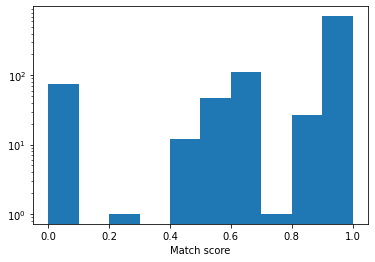

In [7]:
# show distribution first
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
valid_annotated_data = list(filter(lambda x: len(x['additional_answers']) > 0, annotated_data))
overlap_scores = list(map(lambda x: compute_overlap_score(x['label_norm'], x['annotations_norm']), valid_annotated_data))
plt.hist(overlap_scores)
plt.xlabel("Match score")
plt.yscale('log')
plt.show()

In [8]:
import numpy as np
print(f'{(np.array(overlap_scores) == 1.0).sum() / len(overlap_scores)*100}% of captions with at least one complete overlap')

72.08121827411168% of captions with at least one complete overlap


Most questions have fairly low rate of exact matches, which may be unusually low for questions with higher number of annotations provided.

In [9]:
## compute average overlap per NP
valid_annotated_data_labels = list(map(lambda x: x['label_norm'], valid_annotated_data))
label_annotation_overlap = pd.DataFrame(list(zip(valid_annotated_data_labels, overlap_scores)), columns=['label', 'overlap_score'])
label_annotation_overlap_aggregate = label_annotation_overlap.groupby('label').apply(lambda x: x.loc[:, 'overlap_score'].mean())
label_annotation_overlap_aggregate.sort_values(inplace=True, ascending=False)
print('ground-truth labels with highest annotation overlap')
display(label_annotation_overlap_aggregate.head(20))
label_annotation_overlap_aggregate.sort_values(inplace=True, ascending=True)
print('ground-truth labels with lowest annotation overlap')
display(label_annotation_overlap_aggregate.head(20))

ground-truth labels with highest annotation overlap


label
mountain           1.0
folding            1.0
mat                1.0
black marker       1.0
meat               1.0
mechanical bull    1.0
mel                1.0
melody             1.0
member             1.0
men                1.0
message            1.0
metal              1.0
birthday candle    1.0
laser guns         1.0
michael jackson    1.0
bikini             1.0
big belly          1.0
milk               1.0
mixture            1.0
mosh pit           1.0
dtype: float64

ground-truth labels with lowest annotation overlap


label
about nine game pieces      0.0
hop scotch                  0.0
human pusher                0.0
cement plaster              0.0
skating ring                0.0
components                  0.0
sliverware                  0.0
twos                        0.0
sleeper top                 0.0
voices                      0.0
anvil                       0.0
timelapse                   0.0
building block formation    0.0
time                        0.0
wind                        0.0
themselves                  0.0
taekwondo                   0.0
another item                0.0
soft melody                 0.0
studio                      0.0
dtype: float64

The words with higher agreement tend to be simple and concrete nouns (`keyboard`, `knife`).

The words with lower agreement tend to be highly specific (`about nine game pieces`, `cameraman`) or vague (`another item`, `swirl`).

## Tokens per NP
How many tokens on average does each noun phrase contain?

We'll look at this for both ground-truth and annotations.

gold label NPs have 1.470 +/- 0.686 tokens
annotation NPs have 1.364 +/- 0.691 tokens


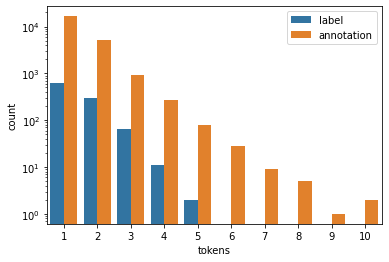

In [10]:
from nltk.tokenize import WordPunctTokenizer
import numpy as np
tokenizer = WordPunctTokenizer()
label_token_counts = list(map(lambda x: len(tokenizer.tokenize(x)), valid_annotated_data_labels))
flat_annotation_labels = [z for x in valid_annotated_data for y in x['annotations_norm'] for z in y]
# remove null labels?
flat_annotation_labels = list(filter(lambda x: len(x) > 0, flat_annotation_labels))
annotation_label_token_counts = [len(tokenizer.tokenize(x)) for x in flat_annotation_labels]
print('gold label NPs have %.3f +/- %.3f tokens'%(np.mean(label_token_counts), np.std(label_token_counts)))
print('annotation NPs have %.3f +/- %.3f tokens'%(np.mean(annotation_label_token_counts), np.std(annotation_label_token_counts)))
## get combined counts => show as bar chart
label_token_count_bins = pd.Series(label_token_counts).value_counts().reset_index().assign(**{'data_type' : 'label'})
annotation_label_token_count_bins = pd.Series(annotation_label_token_counts).value_counts().reset_index().assign(**{'data_type' : 'annotation'})
combined_token_count_bins = pd.concat([
    label_token_count_bins,
    annotation_label_token_count_bins,
]).rename(columns={'index' : 'tokens', 0 : 'count'})
import seaborn as sns
sns.barplot(y='count', x='tokens', data=combined_token_count_bins, hue='data_type')
plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

The gold labels tend to be slightly longer, and annotation labels are more central-skewed (2 words or below) vs. the long tail of tokens in the gold labels.

What are the longest/shortest labels in each set?

In [11]:
label_token_count_data = pd.Series(label_token_counts, index=list(map(lambda x: x.lower(), valid_annotated_data_labels))).sort_values(inplace=False, ascending=False)
flat_annotation_label_token_count_data = pd.Series(annotation_label_token_counts, index=list(map(lambda x: x.lower(), flat_annotation_labels))).sort_values(inplace=False, ascending=False)
label_token_count_data = label_token_count_data[~label_token_count_data.index.duplicated()]
flat_annotation_label_token_count_data = flat_annotation_label_token_count_data[~flat_annotation_label_token_count_data.index.duplicated()]
print('longest gold label NPs')
display(label_token_count_data.head(20))
print('longest annotation NPs')
display(flat_annotation_label_token_count_data.head(20))

longest gold label NPs


innocent cute little baby boy    5
black and white knitting kit     5
basic photo copy machine         4
his toy train set                4
his rock climbing equipment      4
about nine game pieces           4
very well built woman            4
large multiple dig site          4
ornately costumed dance squad    4
complex stretching yoga pose     4
strung out teenage girls         4
her very colorful leggings       4
human ping pong ball             4
two hockey teams                 3
each others heads                3
indoor swimming pool             3
indoor basketball court          3
strict pull ups                  3
another young woman              3
two little boys                  3
dtype: int64

longest annotation NPs


how she always has handful of dog food to start        10
2 teams one in yellow jerseys and one white jerseys    10
poor animal who needs its wool to stay warm             9
cowboy wearing blue jeans and blue jean jacket          8
2 people total and 1 in full view                       8
male wearing shoes and black pants with stripes         8
2 young kids with shorts and no shirts                  8
boy in black and boy in blue tshirt                     8
2 males wearing blue shirt and shorts                   7
while sitting and using fork to eat                     7
girl in tshirt and bathing suit bottom                  7
infant who is just learning to speak                    7
shirtless man with black bottom bathing suit            7
another person that is laying on table                  7
kid in black shirt and black pants                      7
large piece of what looks like granite                  7
man in white shirt and black pants                      7
grass area nex

The longest NPs for the gold labels tend to have multiple adjectives (`an innocent cute little baby boy`) and possessive markers (`a man's back`).

The longest NPs for the annotation labels tend to have coordination (`a man in shorts and black t-shirt`) and long, unnecessary subclauses (`the poor animal who needs it's wool to stay warm`).

### Unique NPs per question
How many unique NPs does each question get?

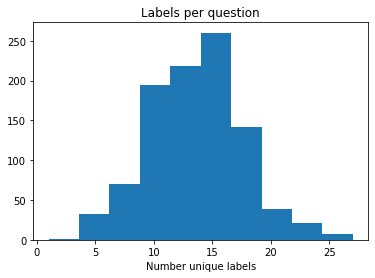

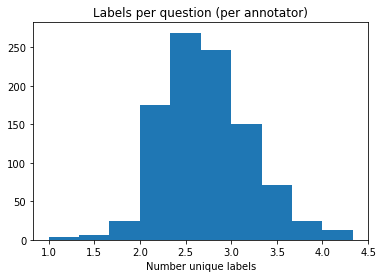

questions have an average of 13.463 +/- 3.930 unique labels
annotators have an average of 2.676 +/- 0.483 unique labels


In [12]:
def get_num_unique_labels_per_annotator(data):
    ## TODO: only include first label from each annotator? some annotators may have included extra words just for bonus
    data_annotation_label_sets = [set([y.lower() for y in x]) for x in data['annotations_norm']]
    num_unique_data_annotation_labels = list(map(lambda x: len(x), data_annotation_label_sets))
    mean_unique_data_annotation_labels = np.mean(num_unique_data_annotation_labels)
    return mean_unique_data_annotation_labels
unique_labels_per_question = list(map(lambda x: list(sorted(set([z.lower() for y in x['annotations_norm'] for z in y]))), valid_annotated_data))
num_unique_labels_per_question = list(map(lambda x: len(x), unique_labels_per_question))
num_unique_labels_per_question_per_annotator = list(map(lambda x: get_num_unique_labels_per_annotator(x), valid_annotated_data))
plt.hist(num_unique_labels_per_question)
plt.xlabel('Number unique labels')
plt.title('Labels per question')
plt.show()
plt.hist(num_unique_labels_per_question_per_annotator)
plt.xlabel('Number unique labels')
plt.title('Labels per question (per annotator)')
plt.show()
print('questions have an average of %.3f +/- %.3f unique labels'%(np.mean(num_unique_labels_per_question), np.std(num_unique_labels_per_question)))
print('annotators have an average of %.3f +/- %.3f unique labels'%(np.mean(num_unique_labels_per_question_per_annotator), np.std(num_unique_labels_per_question_per_annotator)))

Most questions have around 13 unique labels total and 2.7 unique labels per annotator.

Which questions have the most unique labels per annotator?

In [13]:
pd.set_option('display.max_colwidth', 200)
question_prompts = list(map(lambda x: x['masked_caption'], valid_annotated_data))

unique_labels_per_question_per_annotator_data = pd.DataFrame([
    question_prompts,
    num_unique_labels_per_question_per_annotator,
    unique_labels_per_question,
], index=['prompt', 'unique_label_count', 'unique_labels']).transpose()
unique_labels_per_question_per_annotator_data.sort_values('unique_label_count', inplace=True, ascending=False)
print('questions with highest number unique labels per annotator')
display(unique_labels_per_question_per_annotator_data.head(10))
print('questions with lowest number unique labels per annotator')
display(unique_labels_per_question_per_annotator_data.tail(10))

questions with highest number unique labels per annotator


,prompt,unique_label_count,unique_labels
936,_____ kicks soccer balls into a net while on a grass field.,4.33333,"[adolescent, athlete, boy, child, guy, human, kid, male, my daughters friend, our neighbor, person, player, players, soccer player, someone, son, team member, teams captain, young boy, youth]"
590,_____ peels a potato with an extra large peeler than can also be used on zucchini.,4.125,"[chef, cook, female, female chef, female cook, girl, host, lady, mother, older chef, older cook, older woman, person, some lady in her kitchen, someone, woman]"
428,A group of _____ in pink tutus dancing in a circle on stage.,4.11111,"[arminarm girls, balet students, ballerinas, children, dancers, girls, kids, little girls, little kids, students, toddlers, young ballerinas, young dancers, young girls]"
261,A man is walking by _____ that is completely full then comes back and smashes the computer monitor sitting on top with a baseball bat.,4.11111,"[alley, bin, black bin, black bin with garbage, black garbage bin, black rubbish bin, black trash can, black trashcan, can, dumpster, garbage bin, garbage can, garbage receptacle, grey garbage can..."
606,_____ is styling a person's hair using a blow dryer and brush.,4.11111,"[barber, beautician, businessperson, cosmetologist, educator, female hairdresser, girl, hair stylist, hairdresser, lady, person, someone, stylist, woman, woman hairdresser, womens hairstylist, you..."
577,_____ plays an instrument while wearing a pink shirt.,4.11111,"[artist, bald man, dude, entertainer, guy, individual, male, man, musician, old man, older man, performer, person, saxophone player, saxophonist, singer, somebody, someone, this bloke]"
158,_____ are each wrapping Christmas presents on a coffee table.,4.11111,"[2 boys, 2 kids, 3 boys, boys, brothers, children, kids, little boys, little kids, people, siblings, two boys, two boys in pajamas, two children, two kids in pajamas, two little boys, two little c..."
181,A kid riding a skateboard while a group of _____ are watching and music plays.,4,"[amateur skateboarders, boys, bros, bystanders, children, fans, friends, girls, guys, kids, men, others, people, skate parkgoers, skateboarders, skaters, spectators, teenagers, teens, women, young..."
846,A man wearing _____ and hood speaks while sitting and smoking a pipe.,4,"[beard, blue jacket, clothes, fleece sweatshirt, goatee, gray hood, gray hoodie, gray jacket, gray sweatshirt, grey hood, grey hoodie, grey jacket, grey sweatshirt, hood, hoodie, jacket, plaid, sh..."
905,A group of drivers race cars on _____ in front of onlookers.,4,"[circuit, clay, course, dirt, dirt path, dirt track, dry sand, field, ground, mud, race grounds, race track, racetrack, raceway, round dirt track, round track, sand, speedway, stretch, track]"


questions with lowest number unique labels per annotator


,prompt,unique_label_count,unique_labels
469,A man juggles balls one-handed and then two-handed and tosses them to a person off-_____.,1.625,"[balance, camera, frame, screen, shot]"
331,A woman talks about a beautiful scrapbook that _____ made that has many embelishments.,1.625,"[herself, noel, people, she, someone, someone else]"
901,"In the baseball game, the pitcher sends a ball and the batter does _____.",1.6,"[big swing, hit, hits ball out in field, homerun, job, something great, what he does best]"
863,The man in _____ checks and trims the toenails of a small animal.,1.55556,"[black pants, black sweater, chair, clip, knit shirt, sweater, vets office, video, warm sweater]"
925,"Dressed in all of the gear, one fencer advances on _____ as they compete.",1.5,"[another fencer, fighter, his competitor, his opponent, opponent, rival, their opponent]"
748,"A man, outdoors at a gas station, is demonstrating step-by-_____, how to pump gas.",1.42857,"[demonstration, instruction, step, way]"
721,A young boy who seems to be timing _____ how fast he can eat a snack.,1.28571,"[challenge of, himself, his self, recording of, to calculate, to see]"
706,Packages of paper are being wrapped in paper plastic and stacked on _____ of each other.,1.25,"[device next, machine, row, side, top]"
142,A baby is listening to a lady's song as _____.,1,[smiles]
847,A person is showing how _____ open a beer with a screw driver indoors.,1,"[he, people, to screw open, you]"


Questions with higher number of unique labels seem to inspire creative answers (`a group of ____ in pink tutus` => different paraphrases for `child`) and address multiple possible aspects of an event due to ambiguity (`a man wearing ____` => many possible clothing items).

Questions with lower number of unique labels seem to have very specific scenarios without room for paraphrasing or ambiguity (`step-by-____` => the blank can only be "step").

### Assessing visual cues
Some nouns and adjectives have more obvious visual cues than others, ex. "green" has clear visual component whereas "kind" is more subjective.

Let's look for these visual cues in the labels and annotations using some word lists:
- color
- size
- number

In [29]:
## TODO: expand word sets using word embeddings (nearest neighbors + filtering)
color_words = {
    'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'black', 'white', 'gray', 'grey',
    'colorful', 'painted',
}
size_words = {
    'large', 'huge', 'giant', 'small', 'little', 'tiny',
}
number_words = {
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'several', 'few', 'many',
}
combined_visual_words = (color_words | size_words | number_words)
visual_word_sets = [
    color_words, size_words, number_words, combined_visual_words,
]
visual_word_set_names = [
    'color', 'size', 'number', 'combined'
]

In [23]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.metrics import tokenize_answer_to_compute_metrics
## tokenize everything
label_tokens = list(map(lambda x: tokenize_answer_to_compute_metrics(x['label_norm']), annotated_data))
annotation_label_tokens = [[tokenize_answer_to_compute_metrics(z) for z in y] for x in valid_annotated_data for y in x['annotations_norm']]

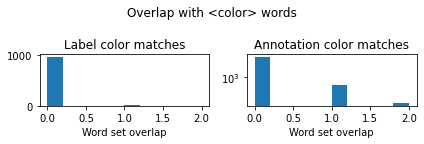

proportion of <color> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.984864                   0.987302
1           1              0.014127                   0.011961
2           2              0.001009                   0.000737
percent of labels with >= 1 matches: 
(label_word_match_pct         0.015136
annotation_word_match_pct    0.012698
dtype: float64,)


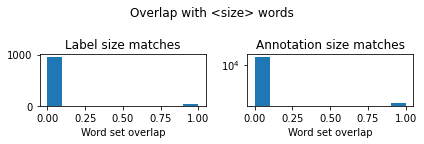

proportion of <size> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.968718                   0.990943
1           1              0.031282                   0.009057
percent of labels with >= 1 matches: 
(label_word_match_pct         0.031282
annotation_word_match_pct    0.009057
dtype: float64,)


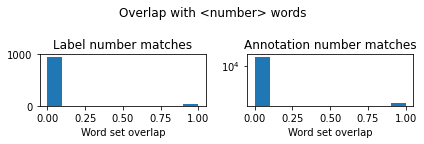

proportion of <number> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.963673                   0.986479
1           1              0.036327                   0.013521
percent of labels with >= 1 matches: 
(label_word_match_pct         0.036327
annotation_word_match_pct    0.013521
dtype: float64,)


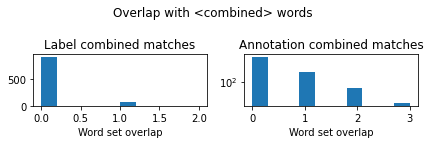

proportion of <combined> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.921292                   0.965244
1           1              0.073663                   0.033543
2           2              0.005045                   0.001170
3           3                   NaN                   0.000043
percent of labels with >= 1 matches: 
(label_word_match_pct         0.078708
annotation_word_match_pct    0.034756
dtype: float64,)


In [32]:
## get counts, plot distribution of visual words
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
for visual_word_set, visual_word_set_name in zip(visual_word_sets, visual_word_set_names):
    label_word_matches = list(map(lambda x: set(x) & visual_word_set, label_tokens))
    annotation_label_word_matches = [set(y) & visual_word_set for x in annotation_label_tokens for y in x]
    num_label_word_matches = list(map(lambda x: len(x), label_word_matches))
    num_annotation_label_word_matches = list(map(lambda x: len(x), annotation_label_word_matches))
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
    axs[0].hist(num_label_word_matches)
    axs[1].hist(num_annotation_label_word_matches)
    axs[0].set_title(f'Label {visual_word_set_name} matches')
    axs[1].set_title(f'Annotation {visual_word_set_name} matches')
    axs[0].set_xlabel('Word set overlap')
    axs[1].set_xlabel('Word set overlap')
    plt.suptitle(f'Overlap with <{visual_word_set_name}> words')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    # compute proportion of visual words per question
    pct_label_word_matches = pd.Series(num_label_word_matches).value_counts() / len(num_label_word_matches)
    pct_annotation_label_word_matches = pd.Series(num_annotation_label_word_matches).value_counts() / len(num_annotation_label_word_matches)
    pct_word_matches = pd.concat([pct_label_word_matches, pct_annotation_label_word_matches], axis=1).reset_index()
    pct_word_matches.columns = ['word_count', 'label_word_match_pct', 'annotation_word_match_pct']
#     pct_word_matches.columns = ['label_match_pct', 'annotation_label_match_pct']
    print(f'proportion of <{visual_word_set_name}> word matches for labels:\n{pct_word_matches}')
    # simplify: percent with >=1 words
    above_1_pct_word_matches = pct_word_matches[pct_word_matches.loc[:, 'word_count'] >= 1].iloc[:, 1:].sum(axis=0),
    print(f'percent of labels with >= 1 matches: \n{above_1_pct_word_matches}')

Overall, the annotations tend to have about the rate of color words as the labels, but the annotations also have fewer size and number words than the labels.

What are some example questions where the label contains a visual word but the annotations do not?

In [33]:
## get aligned/valid data
valid_label_tokens = list(map(lambda x: tokenize_answer_to_compute_metrics(x['label_norm']), valid_annotated_data))
valid_annotation_label_tokens = [[tokenize_answer_to_compute_metrics(z) for y in x['annotations_norm'] for z in y] for x in valid_annotated_data]
# flatten tokens
valid_annotation_label_tokens = [[z for y in x for z in y] for x in valid_annotation_label_tokens]
sample_size = 10
for visual_word_set, visual_word_set_name in zip(visual_word_sets, visual_word_set_names):
    print(f'*~*~*~* testing word set {visual_word_set_name} *~*~*~*')
    label_word_matches = list(map(lambda x: set(x) & visual_word_set, valid_label_tokens))
    annotation_label_word_matches = list(map(lambda x: set(x) & visual_word_set, valid_annotation_label_tokens))
    sample_ctr = 0
    for data_i, label_word_matches_i, annotation_label_word_matches_i in zip(valid_annotated_data, label_word_matches, annotation_label_word_matches):
        if(len(label_word_matches_i) > 0 and len(annotation_label_word_matches_i) == 0):
            print(f'caption=<{data_i["caption"]}>')
            print(f'label=<{data_i["label"]}> has matches <{label_word_matches_i}>')
            print(f'annotations do not have matches: <{data_i["additional_answers"]}>')
            print('---------')
            sample_ctr += 1
            if(sample_ctr >= sample_size):
                break

*~*~*~* testing word set color *~*~*~*
caption=<A red hot piece of bent steel is being formed with a metal sledge hammer on the end of a  steel table.>
label=<A red hot piece> has matches <{'red'}>
annotations do not have matches: <[['A horseshoe', 'A shoe', 'An arch', 'A U-shape', 'An object'], ['A piece', 'A horseshoe'], ['a rod', 'a segment'], ['hot iron'], ['A large are', 'A big area'], ['A piece', 'A long piece', 'A hot piece'], ['A piece', 'A rod', 'A chunk'], ['A piece', 'A part'], ['A piece', 'A heated piece']]>
---------
caption=<A gir lis trying to stitching up the black and white knitting kit with a knitting needle.>
label=<the black and white knitting kit> has matches <{'white', 'black'}>
annotations do not have matches: <[['string', 'lace work'], ['the neckerchief', 'the scarf'], ['a scarf', 'a line on a scarf'], ['yarn', 'cloth'], ['a piece of clothing', 'some cloth'], ['a scarf', 'fancy yarn'], ['a scarf', 'her scarf'], ['crochet', 'string', 'thread'], ['a scarf', 'some 

- Color: the mismatches are due to highly specific captions, no necessary information being conveyed by the color.
- Size: the mismatches are due to annotators focusing more on paraphrases for the noun (`little baby`: `child`, `infant`) and different aspects of the scene (`large group`: `group`, `skill`).
- Number: the mismatches are due to annotators focusing more on paraphrases for the noun (`two large barbells`: `equipment`, `weights`) and different aspects of the scene (`three wine glasses`: `dishes`, `glasses`).

### Syntactic complexity
Let's look at the relative complexity of the NPs provided by the annotations.

We'll use `spacy` for parsing.

In [34]:
import spacy
nlp_pipeline = spacy.load('en_core_web_sm')
test_text = 'this is a test sentence with a complicated noun that has a lot of extra information'
test_text_parse = nlp_pipeline(test_text)
print(test_text_parse)

this is a test sentence with a complicated noun that has a lot of extra information


In [35]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.noun_phrases import is_phrase
def extract_noun_subtree(noun, start_idx, parse):
    noun_tokens = []
    # get span
    end_idx = start_idx + len(noun)
    subtree = parse.char_span(start_idx, end_idx)
    if(subtree is not None and is_phrase(subtree)):
        return subtree
    else:
        return ''
test_noun = 'a complicated noun that has a lot of extra information'
start_idx = test_text.index(test_noun)
test_noun_subtree = extract_noun_subtree(test_noun, start_idx, test_text_parse)
print(test_noun_subtree)

a complicated noun that has a lot of extra information


In [36]:
## get start index
mask_token = '_____'
for data_i in annotated_data:
    data_i.update({'mask_start_idx' : data_i['masked_caption'].index(mask_token)})
assert annotated_data[0]['mask_start_idx'] == 53

In [37]:
# parse all possible sentences based on annotations, generate sub-trees
def parse_extract_noun_subtree(mask_sent, noun, nlp_pipeline, start_idx, mask_token='_____'):
    sent = mask_sent.replace(mask_token, noun)
    parse = nlp_pipeline(sent)
    subtree = extract_noun_subtree(noun, start_idx, parse)
    return subtree
def extract_all_annotation_subtrees(data, nlp_pipeline):
    mask_token = '_____'
    for i, data_i in enumerate(data):
        start_idx_i = data_i['mask_start_idx']
        mask_sent_i = data_i['masked_caption']
        # get subtree for label
        label_i = data_i['label']
        label_subtree_i = parse_extract_noun_subtree(mask_sent_i, label_i, nlp_pipeline, start_idx_i, mask_token=mask_token)
        data_i['label_subtree'] = label_subtree_i
        annotation_label_subtrees = []
        for annotation_label_list_j in data_i['additional_answers']:
            annotation_label_subtrees_j = []
            for annotation_label_k in annotation_label_list_j:
                annotation_subtree_k = parse_extract_noun_subtree(mask_sent_i, annotation_label_k, nlp_pipeline, start_idx_i, mask_token=mask_token)
                annotation_label_subtrees_j.append(annotation_subtree_k)
            annotation_label_subtrees.append(annotation_label_subtrees_j)
        data_i['annotation_subtrees'] = annotation_label_subtrees
        if(i % 100 == 0):
            print(f'processed {i} data')
    return data
annotated_data = extract_all_annotation_subtrees(annotated_data, nlp_pipeline)

processed 0 data
processed 100 data
processed 200 data
processed 300 data
processed 400 data
processed 500 data
processed 600 data
processed 700 data
processed 800 data
processed 900 data


In [38]:
display(annotated_data[0])

{'video_id': 'cfBtVPEwqIo',
 'video_start_time': 5,
 'video_end_time': 15,
 'caption': 'In a gym with someone spotting him, a man is lifting weights performing squats in a squat rack.',
 'masked_caption': 'In a gym with someone spotting him, a man is lifting _____ performing squats in a squat rack.',
 'label': 'weights',
 'additional_answers': [['a weight', 'some weights', 'a squat bar'],
  ['weight', 'a bar'],
  ['weights', 'a barbell'],
  ['weights', 'a heavy load'],
  ['weights', 'a barbell'],
  ['weights', 'iron', 'equipment'],
  ['weights', 'a barbell', 'a weight'],
  ['weights', '405 lb']],
 'label_norm': 'weights',
 'annotations_norm': [['weight', 'some weights', 'squat bar'],
  ['weight', 'bar'],
  ['weights', 'barbell'],
  ['weights', 'heavy load'],
  ['weights', 'barbell'],
  ['weights', 'iron', 'equipment'],
  ['weights', 'barbell', 'weight'],
  ['weights', '405 lb']],
 'mask_start_idx': 53,
 'label_subtree': weights,
 'annotation_subtrees': [[a weight, some weights, ''],
  

How many labels have extra descriptive information?

In [39]:
from collections import defaultdict
def has_descriptor(subtree):
    # adjective
    # get head noun
    head_noun = subtree.root
    subtree_token_ids = list(map(lambda x: x.idx, subtree))
    # get immediate head noun children
    head_noun_children = list(filter(lambda x: x.idx in subtree_token_ids, list(head_noun.children)))
    has_descriptor = any(list(map(lambda x: x.pos_=='ADJ', head_noun_children)))
    return has_descriptor
# def has_subclause(subtree):
#     # has PREP or COORD
#     pass

In [45]:
test_subtree_1 = annotated_data[0]['annotation_subtrees'][3][1] # true "a heavy load"
test_subtree_2 = annotated_data[0]['annotation_subtrees'][1][1] # false "a bar"
assert has_descriptor(test_subtree_1)
assert not has_descriptor(test_subtree_2)

In [46]:
## get descriptors for everything
from spacy.tokens.span import Span
annotation_descriptors = [[[type(z) is Span and has_descriptor(z) for z in y] for y in x['annotation_subtrees']] for x in annotated_data]
label_descriptors = [type(x['label_subtree']) is Span and has_descriptor(x['label_subtree']) for x in annotated_data]

What are some example labels and annotations with adjectives?

In [47]:
## labels
import numpy as np
np.random.seed(123)
sample_size = 10
label_descriptor_idx = np.where(np.array(label_descriptors))[0]
sample_label_descriptor_idx = np.random.choice(label_descriptor_idx, sample_size, replace=False)
print('sample labels with descriptor information')
for sample_idx_i in sample_label_descriptor_idx:
    print(annotated_data[sample_idx_i]['label_subtree'])
## annotations
sample_annotation_descriptor_idx = []
for i, data_i in enumerate(annotation_descriptors):
    for j, data_j in enumerate(data_i):
        for k, data_k in enumerate(data_j):
            if(data_k):
                sample_annotation_descriptor_idx.append([i,j,k])
sample_annotation_descriptor_idx = np.array(sample_annotation_descriptor_idx)
np.random.shuffle(sample_annotation_descriptor_idx)
sample_annotation_descriptor_idx = sample_annotation_descriptor_idx[:sample_size]
print('sample annotations with descriptor information')
for i,j,k in sample_annotation_descriptor_idx:
    print(annotated_data[i]['annotation_subtrees'][j][k])

sample labels with descriptor information
young girl
another teenage boy
A young man
an evergreen tree
several layers
a long jump
a red flower
a back twist
a makeshift helmet
strict pull ups
sample annotations with descriptor information
his clenched fists
a frozen mountain
Two little kids
slow speed
a large pool
tribal music
a yellow lawn mower
high schoolers
a chipping tool
a white shirt


The labels and annotations seem to use mostly visual adjectives (`blue`, `snowy`, `plastic`, `large`) as well as some subjective ones (`great`, `young`, `makeshift`, `classical`).

Do labels and annotations tend to use the same adjectives?

In [48]:
import pandas as pd
sample_size = 20
## labels
label_descriptors_combined = []
for has_descriptor_i, data_i in zip(label_descriptors, annotated_data):
    if(has_descriptor_i):
        descriptors_i = list(filter(lambda x: x.pos_=='ADJ', data_i['label_subtree']))
        descriptors_i = list(map(lambda x: x.text.lower(), descriptors_i))
        label_descriptors_combined.extend(descriptors_i)
label_descriptor_count = pd.Series(label_descriptors_combined).value_counts()
print('top descriptor adjectives for labels')
display(label_descriptor_count.head(sample_size))
## annotations
annotation_descriptors_combined = []
for has_descriptor_i, data_i in zip(annotation_descriptors, annotated_data):
    for has_descriptor_j, data_j in zip(has_descriptor_i, data_i['annotation_subtrees']):
        for has_descriptor_k, data_k in zip(has_descriptor_j, data_j):
            if(has_descriptor_k):
                descriptors_k = list(filter(lambda x: x.pos_=='ADJ', data_k))
                descriptors_k = list(map(lambda x: x.text.lower(), descriptors_k))
                annotation_descriptors_combined.extend(descriptors_k)
annotation_descriptor_count = pd.Series(annotation_descriptors_combined).value_counts()
print('top descriptor adjectives for annotations')
display(annotation_descriptor_count.head(sample_size))

top descriptor adjectives for labels


young        21
large        16
little        9
small         6
various       5
white         5
other         4
long          4
different     4
indoor        3
red           2
black         2
hot           2
older         2
wooden        2
several       2
high          2
human         2
yellow        2
teenage       2
dtype: int64

top descriptor adjectives for annotations


young        223
little        67
large         66
black         60
white         60
small         57
other         45
older         39
red           34
sharp         33
long          30
old           29
different     25
heavy         25
electric      25
blue          22
musical       22
big           20
high          20
wooden        19
dtype: int64

- Descriptor adjectives for label phrases include age, size, number words.
- Descriptor adjectives for annotation phrases include more color and situation-specific (`electric`, `musical`) words.

Do annotations tend to use more adjectives than original labels?

In [49]:
label_descriptor_use_rate = sum(label_descriptors) / len(annotated_data)
total_annotation_descriptors_combined = sum([sum([len(y) for y in x['additional_answers']]) for x in annotated_data])
annotation_descriptor_use_rate = len(annotation_descriptors_combined) / total_annotation_descriptors_combined
print(f'true labels have %.3f%% descriptor use'%(label_descriptor_use_rate*100))
print(f'annotation labels have %.3f%% descriptor use'%(annotation_descriptor_use_rate*100))
## is this significant?
from scipy.stats import chi2_contingency
contingency_table = [
    [sum(label_descriptors), len(annotated_data) - sum(label_descriptors)], # true label
    [len(annotation_descriptors_combined), total_annotation_descriptors_combined - len(annotation_descriptors_combined)], # annotation label
]
chi2, p_val, dof, expected = chi2_contingency(contingency_table)
print('rate of descriptor use is different with stat=%.3f (p=%.3E)'%(chi2, p_val))

true labels have 14.934% descriptor use
annotation labels have 8.641% descriptor use
rate of descriptor use is different with stat=45.636 (p=1.424E-11)


OK! The labels tend to use descriptors at a significantly higher rate than the annotations.

## POS distribution
Let's look at the overall POS distribution in the labels and annotations.

In [50]:
import pandas as pd
def get_POS_counts(subtree):
    return pd.Series([x.pos_ for x in subtree]).value_counts()
label_POS_counts = pd.concat(list(map(lambda x: get_POS_counts(x['label_subtree']), annotated_data)), axis=1).fillna(0.).sum(axis=1)
annotation_POS_counts = pd.concat([get_POS_counts(z) for x in annotated_data for y in x['annotation_subtrees'] for z in y if type(z) is Span], axis=1).fillna(0.).sum(axis=1)
## normalize values
label_POS_counts = label_POS_counts / label_POS_counts.sum()
annotation_POS_counts = annotation_POS_counts / annotation_POS_counts.sum()
# combine for plotting
combined_POS_counts = pd.concat([
    label_POS_counts.reset_index(name='count').rename(columns={'index' : 'POS'}).assign(**{'data_type' : 'label'}),
    annotation_POS_counts.reset_index(name='count').rename(columns={'index' : 'POS'}).assign(**{'data_type' : 'annotation'}),
])
display(combined_POS_counts.head())

<ipython-input-50-358325fe4076>:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  annotation_POS_counts = pd.concat([get_POS_counts(z) for x in annotated_data for y in x['annotation_subtrees'] for z in y if type(z) is Span], axis=1).fillna(0.).sum(axis=1)


,POS,count,data_type
0,ADJ,0.084278,label
1,ADP,0.000986,label
2,ADV,0.005421,label
3,AUX,0.000493,label
4,CCONJ,0.000493,label


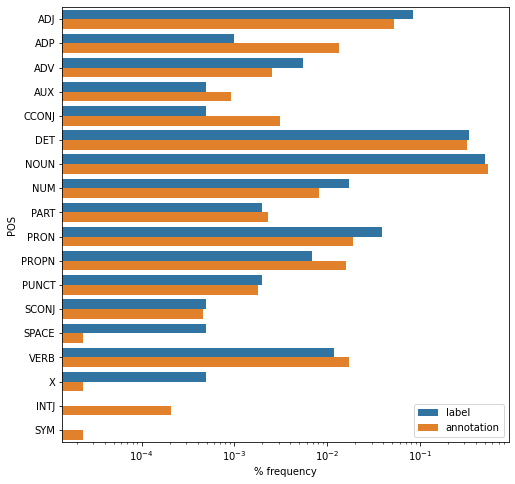

In [51]:
## plot combined
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
sns.barplot(x='count', y='POS', hue='data_type', data=combined_POS_counts)
plt.legend(loc='lower right')
plt.xscale('log')
plt.xlabel('% frequency')
plt.ylabel('POS')
plt.show()

What are the top words in each category?

In [52]:
## get POS/word counts
label_POS_word_counts = []
annotation_POS_word_counts = []
for data_i in annotated_data:
    label_POS_word_counts.extend([(x.text.lower(), x.pos_) for x in data_i['label_subtree']])
    for subtrees_j in data_i['annotation_subtrees']:
        for subtree_k in subtrees_j:
            if(type(subtree_k) is Span):
                annotation_POS_word_counts.extend([(x.text.lower(), x.pos_) for x in subtree_k])
## get aggregate counts!!
label_POS_word_counts = pd.DataFrame(label_POS_word_counts, columns=['word', 'POS'])
annotation_POS_word_counts = pd.DataFrame(annotation_POS_word_counts, columns=['word', 'POS'])
label_POS_word_counts = label_POS_word_counts.groupby('POS').apply(lambda x: x.loc[:, 'word'].value_counts()).reset_index(name='count').rename(columns={'level_1' : 'word'})
annotation_POS_word_counts = annotation_POS_word_counts.groupby('POS').apply(lambda x: x.loc[:, 'word'].value_counts()).reset_index(name='count').rename(columns={'level_1' : 'word'})

In [53]:
for POS_tag_i in combined_POS_counts.loc[:, 'POS'].unique():
    print(f'POS tag {POS_tag_i}')
    label_POS_word_counts_i = label_POS_word_counts[label_POS_word_counts.loc[:, 'POS']==POS_tag_i].sort_values('count', inplace=False, ascending=False).loc[:, ['word', 'count']]
    annotation_POS_word_counts_i = annotation_POS_word_counts[annotation_POS_word_counts.loc[:, 'POS']==POS_tag_i].sort_values('count', inplace=False, ascending=False).loc[:, ['word', 'count']]
    print('label word counts')
    display(label_POS_word_counts_i.head(10))
    print('annotation word counts')
    display(annotation_POS_word_counts_i.head(10))

POS tag ADJ
label word counts


,word,count
0,young,21
1,large,16
2,little,9
3,white,6
4,small,6
5,various,5
6,different,4
7,other,4
8,long,4
9,teenage,3


annotation word counts


,word,count
0,young,226
1,black,74
2,white,71
3,little,67
4,large,66
5,small,58
6,other,50
7,older,39
8,blue,35
9,red,35


POS tag ADP
label word counts


,word,count
89,up,1
90,out,1


annotation word counts


,word,count
527,of,364
528,in,88
529,with,29
530,on,25
531,up,15
532,for,11
533,from,8
534,out,7
535,to,6
536,down,5


POS tag ADV
label word counts


,word,count
91,very,4
92,ornately,1
93,back,1
94,backflip,1
95,well,1
96,curly,1
97,extremely,1
98,about,1


annotation word counts


,word,count
545,how,23
546,back,12
547,very,7
548,else,6
549,well,6
550,chalk,4
551,just,3
552,bong,3
556,shed,2
557,really,2


POS tag AUX
label word counts


,word,count
99,do,1


annotation word counts


,word,count
594,is,12
595,'s,8
596,are,4
597,did,3
598,has,3
599,do,3
600,was,3
601,be,2
602,have,1
603,had,1


POS tag CCONJ
label word counts


,word,count
100,and,1


annotation word counts


,word,count
604,and,127
605,or,2
606,both,2
607,&,1


POS tag DET
label word counts


,word,count
101,a,462
102,the,99
103,his,31
104,an,25
105,her,21
106,their,17
107,another,12
108,some,3
109,both,2
110,its,1


annotation word counts


,word,count
608,a,8792
609,the,3047
610,an,616
611,his,483
612,her,415
613,their,166
614,some,104
615,another,98
616,this,22
617,that,19


POS tag NOUN
label word counts


,word,count
113,man,60
114,person,30
115,woman,28
116,boy,19
117,people,18
118,girl,14
119,group,13
120,boys,11
121,baby,10
122,front,10


annotation word counts


,word,count
633,man,878
634,person,651
635,woman,423
636,people,312
637,boy,288
638,girl,283
639,guy,264
640,group,236
641,child,219
642,kids,164


POS tag NUM
label word counts


,word,count
635,two,24
636,three,7
637,one,2
638,four,1
639,nine,1


annotation word counts


,word,count
3790,two,214
3791,one,41
3792,2,29
3793,three,17
3794,3,12
3795,four,11
3796,2000,4
3797,1,4
3798,4,3
3801,5,2


POS tag PART
label word counts


,word,count
640,'s,4


annotation word counts


,word,count
3809,'s,62
3810,to,36
3811,n't,1


POS tag PRON
label word counts


,word,count
641,it,23
642,them,12
643,he,10
644,someone,10
645,they,5
646,she,4
647,himself,3
648,her,2
649,him,2
650,who,2


annotation word counts


,word,count
3812,someone,221
3813,it,104
3814,he,87
3815,them,67
3816,she,48
3817,something,47
3818,they,33
3819,himself,30
3820,him,27
3821,somebody,25


POS tag PROPN
label word counts


,word,count
656,miami,1
657,jackson,1
658,christmas,1
659,camo,1
660,michael,1
661,english,1
662,diagram,1
663,teams,1
664,mel,1
665,triangular,1


annotation word counts


,word,count
3844,kid,19
3846,chef,10
3847,english,10
3848,christmas,10
3845,lady,10
3849,guy,9
3854,chi,7
3856,teddy,7
3855,tai,7
3857,man,7


POS tag PUNCT
label word counts


,word,count
670,-,4


annotation word counts


,word,count
4245,-,66
4246,",",9
4247,',3


POS tag SCONJ
label word counts


,word,count
671,like,1


annotation word counts


,word,count
4248,while,13
4249,out,3
4250,like,3
4251,that,1


POS tag SPACE
label word counts


,word,count
672,,1


annotation word counts


,word,count
4252,,1


POS tag VERB
label word counts


,word,count
673,flaming,1
674,fold,1
695,sowing,1
694,pull,1
693,motorized,1
692,stretching,1
691,stuffed,1
690,panning,1
689,used,1
688,shown,1


annotation word counts


,word,count
4254,wearing,36
4256,sitting,10
4257,dancing,10
4255,moving,10
4258,playing,9
4259,make,8
4260,cutting,8
4261,stuffed,8
4262,boy,8
4263,colored,8


POS tag X
label word counts


,word,count
697,blacksmith,1


annotation word counts


,word,count
4641,2,1


POS tag INTJ
label word counts


,word,count


annotation word counts


,word,count
631,boy,7
632,man,2


POS tag SYM
label word counts


,word,count


annotation word counts


,word,count
4253,/,1


### POS tag sequences
Let's look at the relative frequency of different tag sequences in the labels and annotations.

In [55]:
from spacy.tokens.span import Span
def get_POS_sequence(subtree):
    return '_'.join([x.pos_ for x in subtree])
label_POS_sequences = [(x['label_subtree'], get_POS_sequence(x['label_subtree'])) for x in annotated_data if type(x['label_subtree']) is Span]
annotation_POS_sequences = [(z, get_POS_sequence(z)) for x in annotated_data for y in x['annotation_subtrees'] for z in y if type(z) is Span]
label_POS_sequences = pd.DataFrame(label_POS_sequences, columns=['word', 'POS_sequence'])
annotation_POS_sequences = pd.DataFrame(annotation_POS_sequences, columns=['word', 'POS_sequence'])
# fix words
label_POS_sequences = label_POS_sequences.assign(**{'word' : label_POS_sequences.loc[:, 'word'].apply(lambda x: x.text.lower())})
annotation_POS_sequences = annotation_POS_sequences.assign(**{'word' : annotation_POS_sequences.loc[:, 'word'].apply(lambda x: x.text.lower())})
# label_POS_sequences = label_POS_sequences[label_POS_sequences.loc[:, 'POS_sequence']!='']
# annotation_POS_sequences = annotation_POS_sequences[annotation_POS_sequences.loc[:, 'POS_sequence']!='']
## get aggregate counts
label_POS_sequence_counts = label_POS_sequences.loc[:, 'POS_sequence'].value_counts()
annotation_POS_sequence_counts = annotation_POS_sequences.loc[:, 'POS_sequence'].value_counts()
# normalize
label_POS_sequence_counts = label_POS_sequence_counts / label_POS_sequence_counts.sum()
annotation_POS_sequence_counts = annotation_POS_sequence_counts / annotation_POS_sequence_counts.sum()

In [56]:
## combine for plotting 
combined_POS_sequence_counts = pd.concat([
    label_POS_sequence_counts.reset_index(name='count').rename(columns={'index' : 'POS_sequence'}).assign(**{'data_type' : 'label'}),
    annotation_POS_sequence_counts.reset_index(name='count').rename(columns={'index' : 'POS_sequence'}).assign(**{'data_type' : 'annotation'}),
], axis=0)
display(combined_POS_sequence_counts)
top_k = 20
top_k_POS_sequences = combined_POS_sequence_counts.groupby('POS_sequence').apply(lambda x: x.loc[:, 'count'].mean()).sort_values(inplace=False, ascending=False).index[:top_k]

,POS_sequence,count,data_type
0,DET_NOUN,0.480533,label
1,NOUN,0.126025,label
2,PRON,0.080943,label
3,DET_ADJ_NOUN,0.079918,label
4,DET_NOUN_NOUN,0.067623,label
...,...,...,...
408,DET_ADJ_AUX,0.000044,annotation
409,NOUN_NOUN_DET_AUX_VERB_ADV,0.000044,annotation
410,ADV_VERB,0.000044,annotation
411,DET_NOUN_PRON_VERB,0.000044,annotation


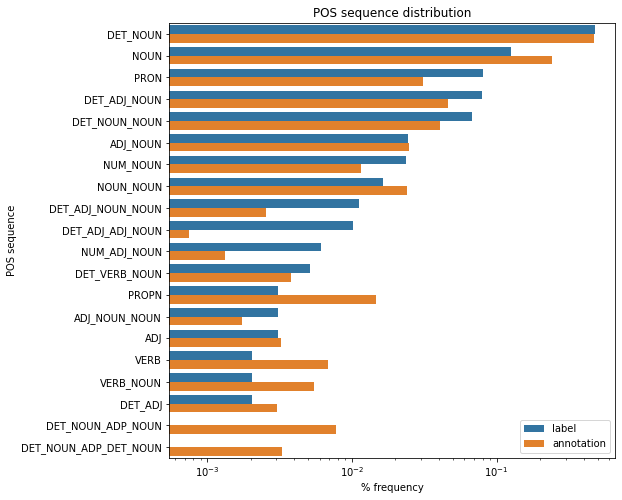

In [60]:
## plot counts
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
sns.barplot(x='count',y='POS_sequence', hue='data_type',
    data=combined_POS_sequence_counts[combined_POS_sequence_counts.loc[:, 'POS_sequence'].isin(top_k_POS_sequences)])
plt.xscale('log')
plt.legend(loc='lower right')
plt.title('POS sequence distribution')
plt.xlabel('% frequency')
plt.ylabel('POS sequence')
plt.xscale('log')
plt.show()

Fewer pronouns for annotations than for labels. Similar levels of adjectives.

In [61]:
## most frequent words for different sequences
top_k = 10
for POS_sequence_i in label_POS_sequence_counts.index[:top_k]:
    print(f'testing POS sequence {POS_sequence_i}')
    label_POS_sequences_i = label_POS_sequences[label_POS_sequences.loc[:, 'POS_sequence']==POS_sequence_i]
    annotation_POS_sequences_i = annotation_POS_sequences[annotation_POS_sequences.loc[:, 'POS_sequence']==POS_sequence_i]
    ## get counts
    label_word_counts_i = label_POS_sequences_i.loc[:, 'word'].value_counts()
    annotation_word_counts_i = annotation_POS_sequences_i.loc[:, 'word'].value_counts()
    # normalize
    label_word_counts_i = label_word_counts_i / label_word_counts_i.sum()
    annotation_word_counts_i = annotation_word_counts_i / annotation_word_counts_i.sum()
    print(f'label word counts\n{label_word_counts_i.head(10)}')
    print(f'annotation word counts\n{annotation_word_counts_i.head(10)}')

testing POS sequence DET_NOUN
label word counts
a man        0.098081
a person     0.057569
a woman      0.044776
a group      0.021322
a boy        0.017058
a piece      0.014925
a girl       0.012793
a child      0.010661
the water    0.010661
a bowl       0.008529
Name: word, dtype: float64
annotation word counts
a person    0.048907
a man       0.048434
a woman     0.023460
a guy       0.019582
a group     0.013906
a boy       0.013622
a girl      0.013055
a child     0.012676
a kid       0.011541
a lady      0.010879
Name: word, dtype: float64
testing POS sequence NOUN
label word counts
people      0.105691
front       0.081301
men         0.032520
music       0.032520
material    0.016260
wood        0.016260
others      0.016260
dogs        0.016260
cards       0.016260
kids        0.016260
Name: word, dtype: float64
annotation word counts
people      0.034934
man         0.016921
kids        0.016739
music       0.014374
men         0.012009
boys        0.010917
front       0.0

- `PRON`: Annotations tend to use more specific pronoun phrases like `someone` or `something` rather than `it`.
- `DET_NOUN`: annotations are less gender-biased? Prefer `person` over `man`.